**`ICUBAM`: ICU Bed Availability Monitoring and analysis in the *Grand Est région* of France during the COVID-19 epidemic.**

https://doi.org/10.1101/2020.05.18.20091264

Python notebook for the sir-like modeling (see Section IV.1 of the main paper).

(ii) visualize results from maximum likelihood estimation, reproducing Fig. 17(left) of the paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os.path as op

import model_icubam as micu

In [2]:
sns.set_style('whitegrid', {'grid.linestyle': ':'})

In [3]:
data_pop = pd.read_csv(op.join('data', 'pop_dep_2020.csv'), delimiter='\t')

first_date = '2020-03-19'
last_date = '2020-04-29'

data = pd.read_csv(op.join(micu.data_path, 'all_bedcounts_2020-05-04_11h02.csv'), index_col=0)              
data = data.groupby(['date', 'department']).sum().reset_index()
data = data[data.date >= first_date]
data = data[data.date <= last_date]

In [4]:
df_params_hat = pd.read_csv(op.join(micu.model_path, 'params_hat_{}.csv'.format(last_date)), index_col=0)              
sites = df_params_hat.dep.values
params_hat = df_params_hat[[col for col in df_params_hat.columns if not col.startswith('dep')]].values

n_sites = len(sites)

depname2depid = {'Ardennes':8, 'Aube':10, 'Marne':51, 'Haute-Marne':52,
                 'Meurthe-et-Moselle':54, 'Meuse':55, 'Moselle':57, 'Bas-Rhin':67,
                 'Haut-Rhin':68, 'Vosges':88}

In [5]:
micu.make_dir(micu.fig_path)

compute_model = micu.compute_model_seir

In [6]:
def plot_model(fun_model, data, sites, params, n_days_pred=0):   
    n_sites = len(sites)
    for k, dep in enumerate(sites):
        if n_sites == 1:
            ax = plt.subplot(111)
        else:
            ax = plt.subplot(np.ceil(n_sites/2), 2, k+1)
        condition = data.department==dep
        pop = data_pop[data_pop.dep=='{}'.format(depname2depid[dep])]['pop'].values[0]
        
        # data
        line_rea = plt.plot(data[condition].date, 
                 data[condition]['n_covid_occ'].values, 
                 'o-', color='tab:red', markersize=5)        
        line_out = plt.plot(data[condition].date, 
                 data[condition]['n_covid_deaths'].values
                 +data[condition]['n_covid_healed'].values, 
                 'o-', color='0.4', markersize=5)  
        # model
        n_days = data[condition].date.shape[0]
        c, x = fun_model(pop, params[k], n_days)
        date_rg = pd.date_range(data.date.min(), periods=n_days).strftime('%Y-%m-%d')
        
        plt.plot(date_rg, c, color='tab:red')
        plt.plot(date_rg, x, color='0.4')
    
        ax.set_xticks(ax.get_xticks()[4::7])
        if k < n_sites-2:
            ax.set_xticklabels('')
        else:
            plt.xticks(rotation=60, ha='right', fontsize=9)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))   
        if np.mod(k,2)==0:
            plt.ylabel('number of cases')
        plt.title(dep, fontdict={'fontweight':'bold'} )
        if k==0:
            ax.legend(handles=[line_rea[0], line_out[0]], 
                      labels=['in ICU','discharged cases + deaths'])
    plt.show()

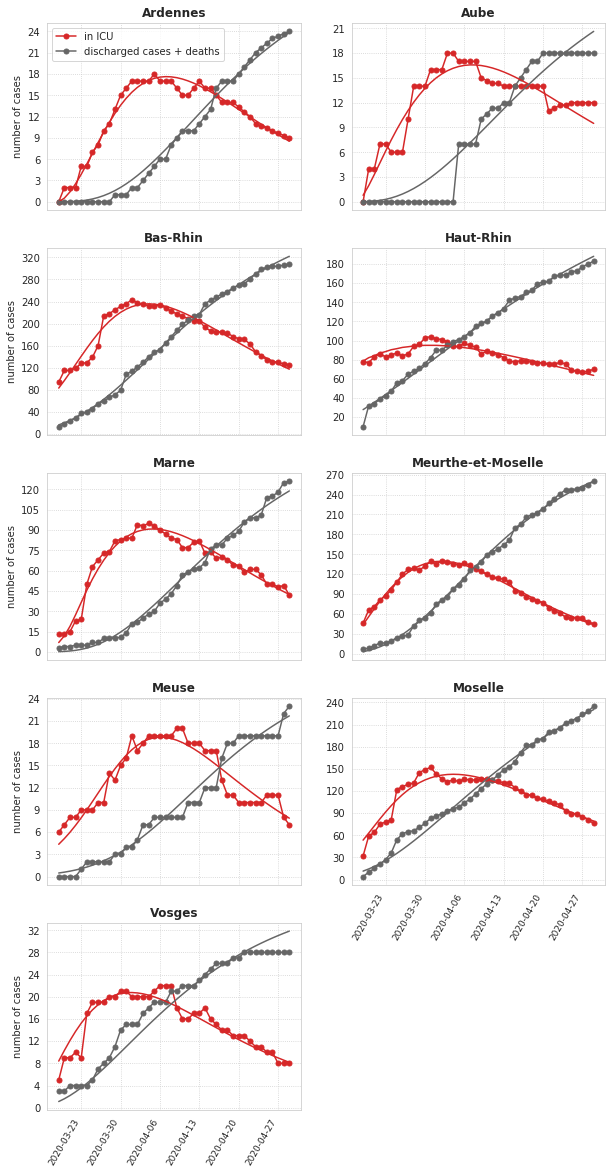

In [7]:
fh = plt.figure(figsize=(10,4*np.ceil(n_sites/2)))
plot_model(compute_model, data, sites, params_hat, n_days_pred=0)
fh.savefig(op.join(micu.fig_path, 'model_icubam_grand-est_{}.pdf'.format(last_date)),
           bbox_inches='tight')